In [3]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.0 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3423240 sha256=82784f14f9715144b77638ed4192065a023ac54b0b66c2e61d22539892639dba
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [5]:
data = pd.read_csv('data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [8]:
items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.columns = ['item_id', 'sales_value_sum']
items_weights['item_weight'] = items_weights['sales_value_sum'] / items_weights['sales_value_sum'].sum()
items_weights = items_weights[['item_id','item_weight']]

In [9]:
def weighted_random_recommendation(items_weights, n=5):
    recs = np.random.choice(items_weights['item_id'], n, p=items_weights['item_weight'],replace=False)
    return recs.tolist()

In [10]:
%%time

result['weight_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

CPU times: user 2.96 s, sys: 24.7 ms, total: 2.98 s
Wall time: 3.02 s


 - Для сравнения, также добавим просто рандомный, по всей группе товаров, и просто топ5 товаров.

In [11]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [12]:
items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

,user_id,actual,weight_recommendation,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13115508, 1044078, 6534178, 6979253, 821083]","[1101835, 5584522, 13516015, 5999657, 15830835]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[956599, 1085435, 958695, 5567319, 979973]","[958180, 12695533, 2081026, 5569634, 1122306]"


In [13]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [14]:

popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

,user_id,actual,weight_recommendation,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13115508, 1044078, 6534178, 6979253, 821083]","[1101835, 5584522, 13516015, 5999657, 15830835]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[956599, 1085435, 958695, 5567319, 979973]","[958180, 12695533, 2081026, 5569634, 1122306]","[6534178, 6533889, 1029743, 6534166, 1082185]"


## Задание 2. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая случаный на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

- Сначала создадим список топ 5000, потом из него рандомно выберем.

In [15]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [16]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""

    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [17]:

result['random_recommendation_5k'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result.head(2)

,user_id,actual,weight_recommendation,random_recommendation,popular_recommendation,random_recommendation_5k
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13115508, 1044078, 6534178, 6979253, 821083]","[1101835, 5584522, 13516015, 5999657, 15830835]","[6534178, 6533889, 1029743, 6534166, 1082185]","[15511891, 866149, 13008321, 848669, 1069312]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[956599, 1085435, 958695, 5567319, 979973]","[958180, 12695533, 2081026, 5569634, 1122306]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1134522, 1034955, 932179, 888404, 13008314]"


In [18]:
import os, sys
from metrics import precision_at_k, recall_at_k

In [19]:
for name_col in result.columns[1:]:
    print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

1.0:actual
0.0227:weight_recommendation
0.0007:random_recommendation
0.1552:popular_recommendation
0.0077:random_recommendation_5k


- Если отталкиваться от того, что рандомная рекомендация, не несет в себе никакой обобщающей способности, то ограничивая выбор топ 5к покупками, мы немного делаем эту способность выше, т.к мы увеличиваем шанс случайно попасть на в среднем более валидный товар. Когда мы добавляем взвешенный рандомный выбор, мы еще немного добавляем вероятности показать самый популярный товар. Так или иначе все эти методы сходятся к тому, что выгоднее взять просто самые популярные товары.

- В домашке будем фильтровать фиктивный индекс во всех моделях.

In [20]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 6666


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)


In [22]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

-  ItemItemRecommender

/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Лучшее К = 1, Качество precision_at_k: 0.2199


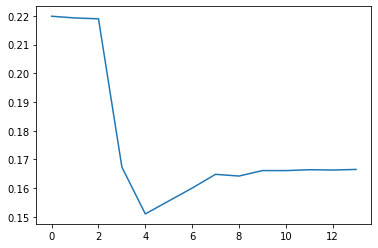

In [23]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
for i in range(1,15):
  model = ItemItemRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

  model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
            show_progress=False)
  result[f'K={i}'] = result['user_id'].\
      apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                      model.recommend(userid=userid_to_id[x], 
                                      user_items=sparse_user_item,   # на вход user-item matrix
                                      N=5, 
                                      filter_already_liked_items=False, 
                                      filter_items=[itemid_to_id[6666]], 
                                      recalculate_user=True)])

model_metrics = []
for name_col in result.columns[2:]:
    model_metrics.append(round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4))
plt.plot(model_metrics)
top_param_k = np.argmax(model_metrics) + 1
print(f'Лучшее К = {top_param_k}, Качество precision_at_k: {model_metrics[top_param_k - 1]}' )


- CosineRecommender

/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Лучшее К = 2, Качество precision_at_k: 0.1763


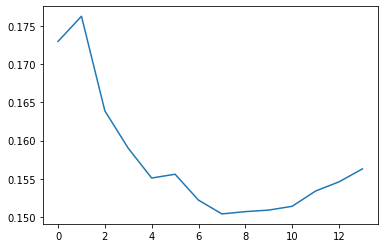

In [24]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
for i in range(1,15):
  model = CosineRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

  model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
            show_progress=False)
  result[f'K={i}'] = result['user_id'].\
      apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                      model.recommend(userid=userid_to_id[x], 
                                      user_items=sparse_user_item,   # на вход user-item matrix
                                      N=5, 
                                      filter_already_liked_items=False, 
                                      filter_items=[itemid_to_id[6666]], 
                                      recalculate_user=True)])

model_metrics = []
for name_col in result.columns[2:]:
    model_metrics.append(round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4))
plt.plot(model_metrics)
top_param_k = np.argmax(model_metrics) + 1
print(f'Лучшее К = {top_param_k}, Качество precision_at_k: {model_metrics[top_param_k - 1]}' )


- TFIDFRecommender

/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


Лучшее К = 2, Качество precision_at_k: 0.1795


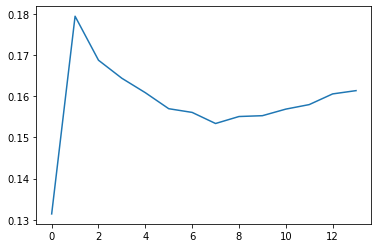

In [25]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
for i in range(1,15):
  model = TFIDFRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

  model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
            show_progress=False)
  result[f'K={i}'] = result['user_id'].\
      apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                      model.recommend(userid=userid_to_id[x], 
                                      user_items=sparse_user_item,   # на вход user-item matrix
                                      N=5, 
                                      filter_already_liked_items=False, 
                                      filter_items=[itemid_to_id[6666]], 
                                      recalculate_user=True)])

model_metrics = []
for name_col in result.columns[2:]:
    model_metrics.append(round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4))
plt.plot(model_metrics)
top_param_k = np.argmax(model_metrics) + 1
print(f'Лучшее К = {top_param_k}, Качество precision_at_k: {model_metrics[top_param_k - 1]}' )


Выходит, что для данной задачи лучше всего подходит ItemItemRecommender с параметром К = 1.